# alpha diversity 

### The phytoplankton alpha diversity is defined as the species richness of a site (Whittaker, 1972).

At times, freshwater zooplankton consume phytoplankton populations at rates similar to or faster than that at which they are growing (Hargrave and Geen, 1970; Gulati, 1975; Horn, 1981; Persson, 1985; Børsheim and Anderson, 1987). Such high losses certainly must help direct seasonal succession as they force a subset of algal species to suffer high mortality rates. Some studies have concluded that losses in general (Kalff and Knoechel, 1978; Reynolds, et al., 1982) and grazing losses in particular (Porter, 1973, 1976, 1977; Lynch and Shapiro, 1981; Crumpton and Wetzel, 1982; Kerfoot, 1987) are important in seasonal succession. In addition, the influence of zooplankton on algal succession is not limited to their selective effect on algal numbers. Zooplankton also interact indirectly with phytoplankton by making some nutrients more available to them (Gliwicz, 1975; Lehman, 1980a, b; Redfield, 1980; Lehman and Scavia, 1982; Sterner, 1986a). Zooplankton thus act not only as predators in the classic sense, but they also have an effect on the competition among algae (Elser et al., 1988).

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib
import matplotlib.colors as colors

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result


In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Input file with output parameters

In [5]:
## Jessica's Path 
jluo_path = '/glade/scratch/jluo/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## Gaby's Path
gabyn_path = '/glade/scratch/gabyn/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

# path 
path_file = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

In [6]:
print('What is the file you want to comapre with? (new_file)?')
new_file = input('')
print('What year is the new_file? (year)')
new_year = input('')

What is the file you want to comapre with? (new_file)?


 GNG595


What year is the new_file? (year)


 20yrclim


In [7]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim/*', recursive=True),
                      key=numericalSort)

In [8]:
ds = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

In [9]:
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'C' for v in phyto_names]
phyBmss = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol
phyBmss = phyBmss.sum(dim='z_t_150m') * 10 #integrate over depth #mmol m-2

## Add biomass threshold, remove biomass that is less than 1.06 mmol/m-2

In [12]:
mask_less_than_zero = phyBmss.values < 1.065 # find all that are less than zero 
new_bmss = phyBmss.values
new_bmss[mask_less_than_zero] = 0 # Make these values zero

In [13]:
new_bmss.shape

(9, 12, 384, 320)

### Sum all the phytoplankton biomasses

In [15]:
phyBmss_total = np.sum(new_bmss, axis=0)

In [16]:
phyBmss_total.shape

(12, 384, 320)

#### This is finding the total biomass at each grid cell, at each month for each phytoplankton and dividing it by the total biomass at that grid cell for each phytoplankton

In [17]:
phyto_frac = np.zeros((9,12,384,320))
for i in range(9):
    phyto_frac[i,:,:,:] = new_bmss[i,:,:,:]/phyBmss_total

### And therefore returns a fraction of biomass for each phytoplankton at each given grid cell for each month

In [18]:
phyto_frac.shape

(9, 12, 384, 320)

In [19]:
phyto_frac[:,0,120,120]*100

array([74.39009547,  2.33247206,  1.45495813, 13.73094469,  0.94717657,
        3.18650976,  0.9563053 ,  2.17259247,  0.82894415])

In [20]:
sum(phyto_frac[:,0,120,120] > 0.025)

3

### Here I am finding the number of phytoplankton present with more than 1% of total biomass at each month and each grid cell. 

In [21]:
index = np.zeros((12,384,320))
for m in range(12):
    for j in range(384):
        for k in range(320):
            index[m,j,k] = sum(phyto_frac[:,m,j,k] > 0.01)

### Here we average the number of phytoplankton present though the year at every location. Where, the number of phytoplankton present at each month were claculated first, and then averaged throughout the year. 

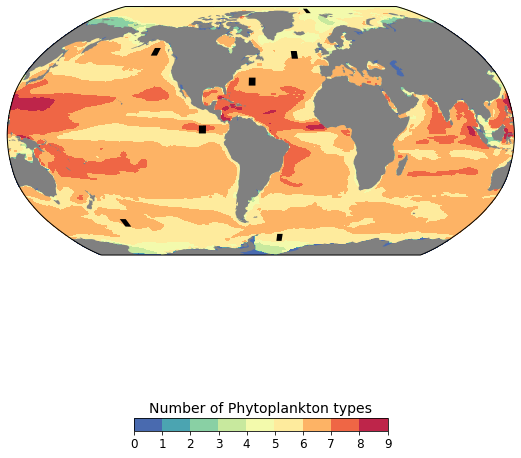

In [22]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(20, 20))
plt.rc('font', size=16)
plt.rc('axes', titlesize=12)
plt.rc('figure', titlesize=18)

lev = np.arange(0, 10, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=5)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(index[:,:,:],axis=0))
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=9,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,1,2,3,4,5,6,7,8,9],shrink=0.5, orientation='horizontal')
cb.ax.set_title('Number of Phytoplankton types', fontsize = 14)
cb.ax.tick_params(labelsize=12)
ax.add_patch(mpatches.Rectangle(xy=[-64, 31], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-145, 50], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-2, 81], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-30, 48], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-99, 1], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-40, -68], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-173, -58], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
#fig.text(0.2, 0.87, 'a',fontsize=16, fontweight='bold')

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/alpha_biomass_monthlyavg'+new_file+'_'+new_year+'_year.png',dpi=600, bbox_inches='tight')

### Now do it with summing all of the phytoplankton at throughout the year instead of creating a mean value of it..

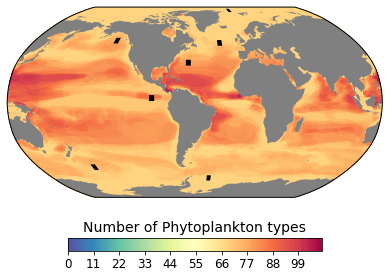

In [23]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(20, 5))
plt.rc('font', size=16)
plt.rc('axes', titlesize=12)
plt.rc('figure', titlesize=18)

lev = np.arange(0, 110, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=55)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, np.sum(index[:,:,:],axis=0))
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=110,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('Number of Phytoplankton types', fontsize = 14)
cb.ax.tick_params(labelsize=12)
ax.add_patch(mpatches.Rectangle(xy=[-64, 31], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-145, 50], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-2, 81], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-30, 48], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-99, 1], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-40, -68], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-173, -58], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
#fig.text(0.2, 0.87, 'a',fontsize=16, fontweight='bold')

#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/alpha_biomass_monthlyavg'+new_file+'_'+new_year+'_year.png',dpi=600, bbox_inches='tight')

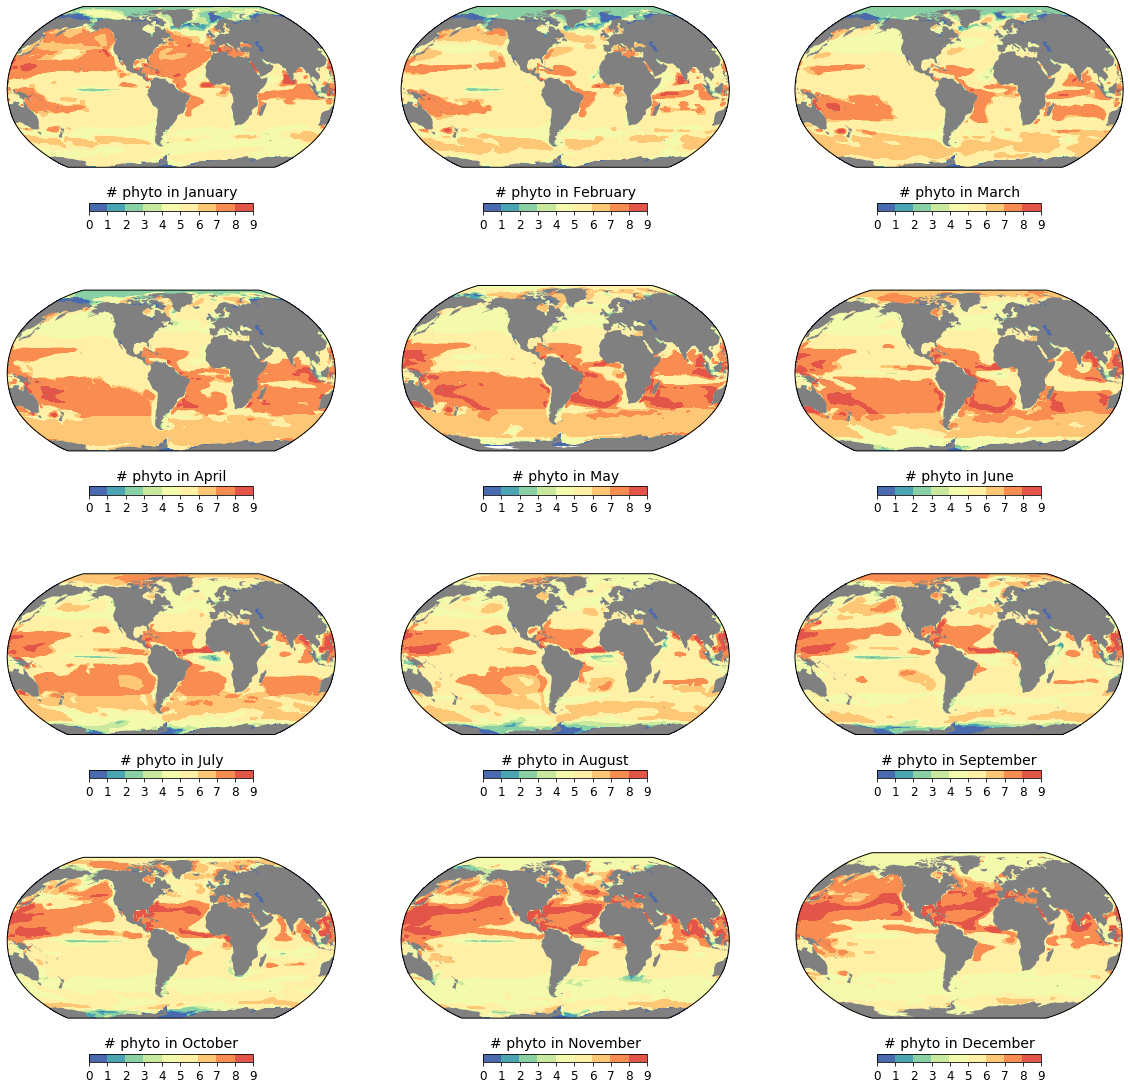

In [24]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(20, 20))
plt.rc('font', size=16)
plt.rc('axes', titlesize=12)
plt.rc('figure', titlesize=18)

lev = np.arange(0, 10, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=5)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, index[0,:,:])
ax = fig.add_subplot(4, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('# phyto in January', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, index[1,:,:])
ax = fig.add_subplot(4, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('# phyto in February', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, index[2,:,:])
ax = fig.add_subplot(4, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('# phyto in March', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, index[3,:,:])
ax = fig.add_subplot(4, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('# phyto in April', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, index[4,:,:])
ax = fig.add_subplot(4, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('# phyto in May', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, index[5,:,:])
ax = fig.add_subplot(4, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('# phyto in June', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, index[6,:,:])
ax = fig.add_subplot(4, 3, 7, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('# phyto in July', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, index[7,:,:])
ax = fig.add_subplot(4, 3, 8, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('# phyto in August', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, index[8,:,:])
ax = fig.add_subplot(4, 3, 9, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('# phyto in September', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, index[9,:,:])
ax = fig.add_subplot(4, 3, 10, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('# phyto in October', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, index[10,:,:])
ax = fig.add_subplot(4, 3, 11, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('# phyto in November', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, index[11,:,:])
ax = fig.add_subplot(4, 3, 12, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('# phyto in December', fontsize = 14)
cb.ax.tick_params(labelsize=12)

### Now I am going to try to average biomass annually first and calculate it that way

In [25]:
phyto_frac_annual = np.zeros((9,384,320))
phyBmss_annual = np.nanmean(new_bmss, axis=1)
phyBmss_total_annual = np.nanmean(phyBmss_total, axis=0)

In [26]:
# Annual
for i in range(9):
    phyto_frac_annual[i,:,:] = phyBmss_annual[i,:,:]/phyBmss_total_annual

In [27]:
phyto_frac_annual[:,120,120]

array([0.7253198 , 0.02109931, 0.01331579, 0.17060818, 0.00868291,
       0.02767069, 0.00864455, 0.01959144, 0.00506748])

In [28]:
index_1 = np.zeros((384,320))
for j in range(384):
    for k in range(320):
        index_1[j,k] = sum(phyto_frac_annual[:,j,k] > 0.001)

In [29]:
index_1[120,120]

9.0

### Here we average the number of phytoplankton present though the year at every location.. so this would technically be alpha diversity. 

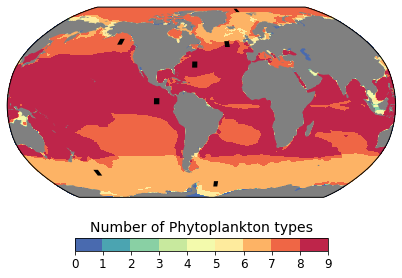

In [30]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(20, 5))
plt.rc('font', size=16)
plt.rc('axes', titlesize=12)
plt.rc('figure', titlesize=18)

lev = np.arange(0, 10, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=5)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, index_1)
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=9,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,1,2,3,4,5,6,7,8,9],shrink=0.5, orientation='horizontal')
cb.ax.set_title('Number of Phytoplankton types', fontsize = 14)
cb.ax.tick_params(labelsize=12)
ax.add_patch(mpatches.Rectangle(xy=[-64, 31], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-145, 50], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-2, 81], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-30, 48], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-99, 1], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-40, -68], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-173, -58], width=5, height=5,
                                    facecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))
#fig.text(0.2, 0.87, 'a',fontsize=16, fontweight='bold')

In [31]:
zoo4_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_20yrclim/remapgrid_GNG595_zoo4C.*.nc', recursive=True))
zoo4_ds = xr.open_mfdataset(zoo4_inds,combine='by_coords')

In [32]:
# (31°40′ N, 64°10′ W)
# longitude in degrees East
EQ_lon = np.where(zoo4_ds.lon == -99)
NA_lon = np.where(zoo4_ds.lon == -30)
SO_lon = np.where(zoo4_ds.lon == -173)
res_lon4 = np.where(zoo4_ds.lon == -40)
BATS_lon = np.where(zoo4_ds.lon == -64)
SPNP_lon = np.where(zoo4_ds.lon == -145)
AO_lon = np.where(zoo4_ds.lon == -2)
SOICE_lon = np.where(zoo4_ds.lon == -40)
SP_lon = np.where(zoo4_ds.lon==-165)

# Latitude degrees_north
EQ_lat = np.where(zoo4_ds.lat == 1.5)
NA_lat= np.where(zoo4_ds.lat == 48.5)
SO_lat= np.where(zoo4_ds.lat == -58.5)
res_lat4 = np.where(zoo4_ds.lat == -68.5)
BATS_lat = np.where(zoo4_ds.lat == 31.5)
SPNP_lat = np.where(zoo4_ds.lat == 50.5)
AO_lat = np.where(zoo4_ds.lat == 81.5)
SOICE_lat = np.where(zoo4_ds.lat == -71.5)
SP_lat = np.where(zoo4_ds.lat== 29.5)

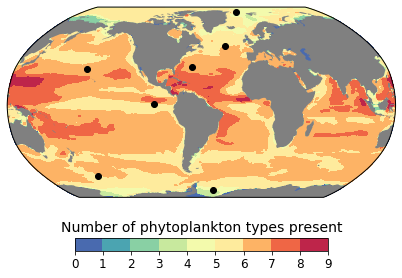

In [33]:
fig = plt.figure(figsize=(20, 5))
plt.rc('font', size=16)
plt.rc('axes', titlesize=12)
plt.rc('figure', titlesize=18)

lev = np.arange(0, 10, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=5)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(index[:,:,:],axis=0))
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=9,levels = lev,norm=norm, transform=ccrs.PlateCarree());
ax.scatter(zoo4_ds.lon[EQ_lon], zoo4_ds.lat[EQ_lat], facecolor='black',transform=ccrs.PlateCarree())
ax.scatter(zoo4_ds.lon[NA_lon], zoo4_ds.lat[NA_lat], facecolor='black',transform=ccrs.PlateCarree())
ax.scatter(zoo4_ds.lon[SO_lon], zoo4_ds.lat[SO_lat], facecolor='black',transform=ccrs.PlateCarree())
ax.scatter(zoo4_ds.lon[BATS_lon], zoo4_ds.lat[BATS_lat], facecolor='black',transform=ccrs.PlateCarree())
ax.scatter(zoo4_ds.lon[SOICE_lon], zoo4_ds.lat[SOICE_lat], facecolor='black',transform=ccrs.PlateCarree())
ax.scatter(zoo4_ds.lon[SP_lon], zoo4_ds.lat[SP_lat], facecolor='black',transform=ccrs.PlateCarree())
ax.scatter(zoo4_ds.lon[AO_lon], zoo4_ds.lat[AO_lat], facecolor='black',transform=ccrs.PlateCarree())


land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,1,2,3,4,5,6,7,8,9],shrink=0.5, orientation='horizontal')
cb.ax.set_title('Number of phytoplankton types present', fontsize = 14)
cb.ax.tick_params(labelsize=12)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/species_richness'+new_file+'_'+new_year+'_year.png',dpi=600, bbox_inches='tight')

### Total Biomass, and biomass of individual phytoplankton

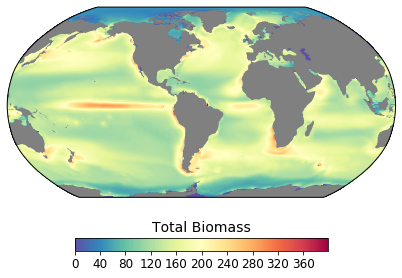

In [34]:
fig = plt.figure(figsize=(20, 5))
plt.rc('font', size=16)
plt.rc('axes', titlesize=12)
plt.rc('figure', titlesize=18)

lev = np.arange(0, 400, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=200)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss_total_annual)
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=400,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('Total Biomass', fontsize = 14)
cb.ax.tick_params(labelsize=12)

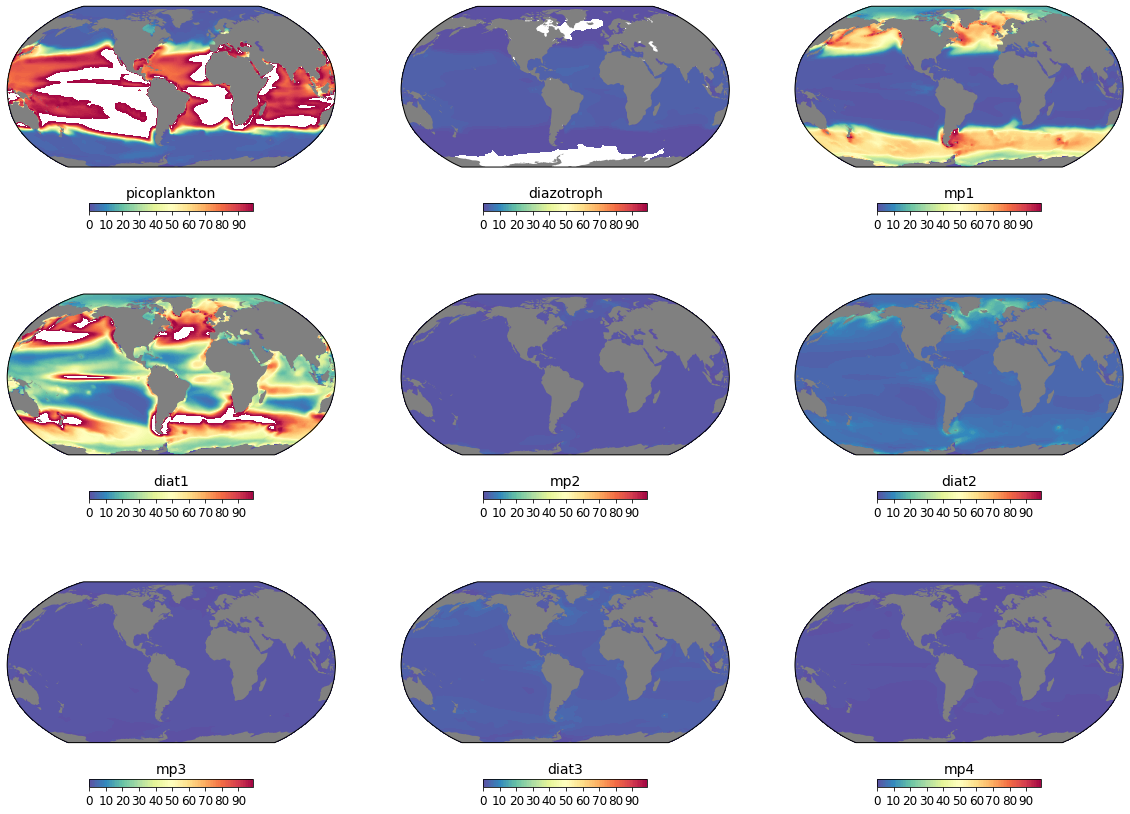

In [66]:
fig = plt.figure(figsize=(20, 15))
plt.rc('font', size=16)
plt.rc('axes', titlesize=12)
plt.rc('figure', titlesize=18)

lev = np.arange(0, 100, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss_annual[0,:,:])
ax = fig.add_subplot(3, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=100,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('picoplankton', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 100, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss_annual[1,:,:])
ax = fig.add_subplot(3, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=100,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('diazotroph', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 100, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss_annual[2,:,:])
ax = fig.add_subplot(3, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=100,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('mp1', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 100, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss_annual[3,:,:])
ax = fig.add_subplot(3, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=100,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('diat1', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 100, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss_annual[4,:,:])
ax = fig.add_subplot(3, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=100,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('mp2', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 100, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss_annual[5,:,:])
ax = fig.add_subplot(3, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=100,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('diat2', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 100, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss_annual[6,:,:])
ax = fig.add_subplot(3, 3, 7, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=100,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('mp3', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 100, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss_annual[7,:,:])
ax = fig.add_subplot(3, 3, 8, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=100,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('diat3', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 100, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss_annual[8,:,:])
ax = fig.add_subplot(3, 3, 9, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=100,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('mp4', fontsize = 14)
cb.ax.tick_params(labelsize=12)

## fraction of total biomass for each phytoplankton group 

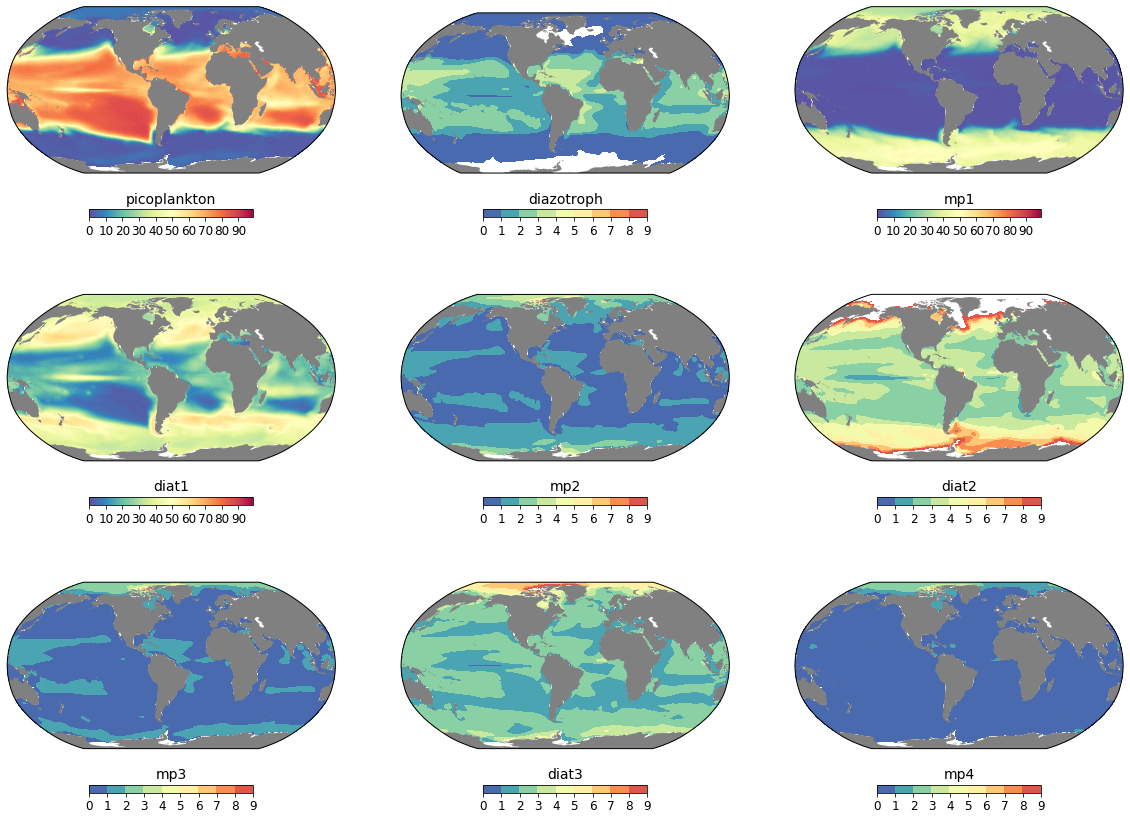

In [67]:
fig = plt.figure(figsize=(20, 15))
plt.rc('font', size=16)
plt.rc('axes', titlesize=12)
plt.rc('figure', titlesize=18)

lev = np.arange(0, 100, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_frac_annual[0,:,:]*100)
ax = fig.add_subplot(3, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=100,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('picoplankton', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 10, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=5)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_frac_annual[1,:,:]*100)
ax = fig.add_subplot(3, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('diazotroph', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 100, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_frac_annual[2,:,:]*100)
ax = fig.add_subplot(3, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=100,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('mp1', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 100, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_frac_annual[3,:,:]*100)
ax = fig.add_subplot(3, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=100,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('diat1', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 10, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=5)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_frac_annual[4,:,:]*100)
ax = fig.add_subplot(3, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('mp2', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 10, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=5)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_frac_annual[5,:,:]*100)
ax = fig.add_subplot(3, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('diat2', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 10, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=5)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_frac_annual[6,:,:]*100)
ax = fig.add_subplot(3, 3, 7, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('mp3', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 10, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=5)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_frac_annual[7,:,:]*100)
ax = fig.add_subplot(3, 3, 8, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('diat3', fontsize = 14)
cb.ax.tick_params(labelsize=12)

lev = np.arange(0, 10, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=5)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_frac_annual[8,:,:]*100)
ax = fig.add_subplot(3, 3, 9, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=10,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('mp4', fontsize = 14)
cb.ax.tick_params(labelsize=12)

### find primary production in (mmol C $m^{-3}$ $d^{-1}$) and compare with species richness. 

In [68]:
total_npp = ds.photoC_TOT.sum(dim='z_t_150m') # mmol/m^3/s
total_npp = total_npp.mean(dim='time') * (60*60*24) # mmol m^-3 d-1

In [69]:
richness = np.mean(index, axis =0)

In [ ]:
from scipy import stats
from scipy.stats import gaussian_kde
fig = plt.figure(figsize=(12, 10))
X=np.array(total_npp).flatten()
Y=np.array(richness).flatten()

# Calculate the 
xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)
plt.scatter(y=Y,x=X, c=z,s=10, alpha=1,cmap='Spectral_r')
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.ylabel('species richness', fontsize=35)
plt.xlabel('primary production (mmol C m$^{-3}$ d$^{-1}$) ',fontsize = 35)
fig.text(0, 0.9, 'c',fontsize=35, fontweight='bold')
plt.colorbar()

In [ ]:
fig = plt.figure(figsize=(12, 10))
X=np.array(total_npp).flatten()
Y=np.array(richness).flatten()
plt.scatter(X,Y)
plt.xlim(0, 9)
plt.ylim(0, 9)
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.ylabel('species richness', fontsize=35)
plt.xlabel('primary production (mmol C m$^{-3}$ d$^{-1}$) ',fontsize = 35)

In [ ]:
fig = plt.figure(figsize=(20, 5))
plt.rc('font', size=16)
plt.rc('axes', titlesize=12)
plt.rc('figure', titlesize=18)

lev = np.arange(0, 10, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=5)
lon, lat, alpha = adjust_pop_grid(ds.TLONG, ds.TLAT, total_npp)
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, alpha, cmap='Spectral_r',vmin = 0, vmax=9,levels = lev,norm=norm, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,1,2,3,4,5,6,7,8,9],shrink=0.5, orientation='horizontal')
cb.ax.set_title('primary production (mmol C m$^{-3}$ d$^{-1}$)', fontsize = 14)
cb.ax.tick_params(labelsize=12)